

---


# ***Pricing data cleaning***

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
products=['Misc School Supplies SKU 17', 'Classification Folders SKU 11']
#selected=0:'Misc School Supplies SKU 17'; selected=1:'Classification Folders SKU 11'
selected=1
df=pd.read_csv('competition_data_2023_09_25.csv')
df=df[df['sku']==products[selected]]
l=df.iloc[0]['min_price']
u=df.iloc[0]['max_price']
df=df[df['price']!=0]
df=df[df['comp_data_min_price']!=0]
df=df[df['comp_data_max_price']!=0]
print((df['max_price'].iloc[0]-df['price'].mean())/(df['max_price'].iloc[0]-df['min_price'].iloc[0]))
df=df.loc[:,['salesdate','price','unitsordered','comp_data_min_price','comp_data_max_price']]
df=df.dropna()
print(df.head())

0.34894651539708255
     salesdate  price  unitsordered  comp_data_min_price  comp_data_max_price
9227  1/1/2022  21.99           1.0                24.52                24.52
9228  1/2/2022  23.99          10.0                24.52                24.52
9229  1/3/2022  23.09          46.0                24.52                24.52
9230  1/4/2022  22.59          41.0                24.52                24.52
9231  1/5/2022  23.39          31.0                24.52                24.52


In [ ]:
#only run this code one time
df['salesdate']=pd.to_datetime(df['salesdate'])
df['day_of_week'] = df['salesdate'].dt.dayofweek
df = pd.get_dummies(df, columns=['day_of_week'], prefix='day', drop_first=False)
print(df.head())

      salesdate  price  unitsordered  comp_data_min_price  \
9227 2022-01-01  21.99           1.0                24.52   
9228 2022-01-02  23.99          10.0                24.52   
9229 2022-01-03  23.09          46.0                24.52   
9230 2022-01-04  22.59          41.0                24.52   
9231 2022-01-05  23.39          31.0                24.52   

      comp_data_max_price  day_0  day_1  day_2  day_3  day_4  day_5  day_6  
9227                24.52  False  False  False  False  False   True  False  
9228                24.52  False  False  False  False  False  False   True  
9229                24.52   True  False  False  False  False  False  False  
9230                24.52  False   True  False  False  False  False  False  
9231                24.52  False  False   True  False  False  False  False  


# ***Fitting models***

In [ ]:
#Fit the unitsordered with linear model

from sklearn.linear_model import LinearRegression
# Assuming 'df' already has the following columns: day_0, ..., day_6, price, unitsordered, comp_data_min_price, comp_data_max_price
# Define features 'x': day columns and competitor price columns
x_columns = ['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'comp_data_min_price', 'comp_data_max_price']

# Create interaction terms: x * price
for col in x_columns:
    df[f'{col}_price'] = df[col] * df['price']
# Combine original x_columns with interaction terms
features = x_columns + [f'{col}_price' for col in x_columns]

# Define the target variable
target = 'unitsordered'

# Prepare data for the model
X = df[features]
y = df[target]

# Fit the linear model
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

# Output coefficients and intercept
print("Model coefficients:", model.coef_)
print("Intercept:", model.intercept_)
theta=model.coef_
theta

Model coefficients: [-1.80683974e+02 -2.62286671e+02 -2.94889549e+02 -2.01897303e+02
 -2.11755496e+02 -2.31950042e+02 -2.43226470e+02  4.75746220e+00
  4.75746220e+00  8.25721699e+00  1.18677863e+01  1.32406745e+01
  9.48884155e+00  9.25802541e+00  8.02651125e+00  8.44074351e+00
 -1.60629945e-01 -1.60629945e-01]
Intercept: 0.0


array([-1.80683974e+02, -2.62286671e+02, -2.94889549e+02, -2.01897303e+02,
       -2.11755496e+02, -2.31950042e+02, -2.43226470e+02,  4.75746220e+00,
        4.75746220e+00,  8.25721699e+00,  1.18677863e+01,  1.32406745e+01,
        9.48884155e+00,  9.25802541e+00,  8.02651125e+00,  8.44074351e+00,
       -1.60629945e-01, -1.60629945e-01])

# ***Generate semi-synthetic data***

In [ ]:
#generate synthetic data

import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal

# Assuming your DataFrame `df` has columns for each day indicator (day_0, day_1, ..., day_6)
# and continuous variables like 'price', 'comp_data_min_price', 'comp_data_max_price'

# Step 1: Identify continuous variables
continuous_vars = ['comp_data_min_price', 'comp_data_max_price']

# Step 2: Prepare to store mean vectors and covariance matrices for each day
params_by_day = {}

# Loop over each day of the week (0 = Monday, ..., 6 = Sunday)
for i in range(7):
    # Extract data for the current day
    day_data = df[df[f'day_{i}'] == 1][continuous_vars]

    # Fit multivariate Gaussian: Calculate mean vector and covariance matrix
    mean_vector = day_data.mean().values
    covariance_matrix = day_data.cov().values

    # Store the parameters
    params_by_day[i] = {
        'mean': mean_vector,
        'cov': covariance_matrix
    }
params_by_day

{0: {'mean': array([31.56932584, 31.56932584]),
  'cov': array([[54.16856318, 54.16856318],
         [54.16856318, 54.16856318]])},
 1: {'mean': array([31.1947191, 31.1947191]),
  'cov': array([[54.4199093, 54.4199093],
         [54.4199093, 54.4199093]])},
 2: {'mean': array([31.44413793, 31.44413793]),
  'cov': array([[54.59130826, 54.59130826],
         [54.59130826, 54.59130826]])},
 3: {'mean': array([31.30170455, 31.30170455]),
  'cov': array([[54.84276833, 54.84276833],
         [54.84276833, 54.84276833]])},
 4: {'mean': array([31.79344828, 31.79344828]),
  'cov': array([[59.29921588, 59.29921588],
         [59.29921588, 59.29921588]])},
 5: {'mean': array([31.60686047, 31.60686047]),
  'cov': array([[62.55135826, 62.55135826],
         [62.55135826, 62.55135826]])},
 6: {'mean': array([31.44785714, 31.44785714]),
  'cov': array([[54.36461945, 54.36461945],
         [54.36461945, 54.36461945]])}}

In [ ]:
def gen(n_days,is_df=0):
    d=len(theta)//2
    if is_df==0:
      generator=np.zeros([0,d])
    else:
      columns = ['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'comp_data_min_price', 'comp_data_max_price']
      generator=pd.DataFrame(columns=columns)
    current_day_index = 0  # Start with day_0 (Monday)
    # Generate data for `n_days` sequential days
    i=0
    while True:
        i+=1
        if i>n_days:
          break
        # Get the mean and covariance for the current weekday
        mean_vector = params_by_day[current_day_index]['mean']
        covariance_matrix = params_by_day[current_day_index]['cov']
        j = 0
        while True:
          j += 1
          if j % 1000 == 0:
            print(j)
          sample = multivariate_normal.rvs(mean=mean_vector, cov=covariance_matrix, size=1)
          a=np.concatenate([[0,0,0,0,0,0,0],sample])
          a[current_day_index]=1

          if np.dot(theta[d:2*d],a)<0 and np.dot(theta[0:d],a)+u*np.dot(theta[d:2*d],a)>0 and sample[0]>=0 and sample[0]<=sample[1]:
            if is_df==0:
              generator=np.vstack([generator,a])
            else:
              generator.loc[len(generator)] = a
            break
          else:
            continue

        # Move to the next day (cycle through 0 to 6)
        current_day_index = (current_day_index + 1) % 7
    return generator

# ***Fit the offline price model***


In [ ]:
#fit the offline price model
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

X = df[['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
        'comp_data_min_price', 'comp_data_max_price']]
y = df['price']

############Linear Model

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Linear Regression model and fit it
pricemodel_linear = LinearRegression(fit_intercept=False)
pricemodel_linear.fit(X_train, y_train)

# Make predictions
y_pred_linear = pricemodel_linear.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred_linear)
mse = mean_squared_error(y_test, y_pred_linear)
print("Linear Regression R-squared:", r2)
print("Linear Regression Mean Squared Error:", mse)


############Kernel Ridge Regression

param_grid = {
    'alpha': [0.05*i for i in range(1,5)],        # Regularization strength
    'kernel': ['rbf'],            # Use the RBF (Radial Basis Function) kernel
    'gamma': [0.05*i for i in range(1,5)]     # Kernel coefficient for RBF kernel
}

# Step 3: Set up GridSearchCV to find the best hyperparameters using cross-validation
krr = KernelRidge()
grid_search = GridSearchCV(krr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Step 4: Fit the model with cross-validation
grid_search.fit(X_train, y_train)

# Get the best parameters and the corresponding model
best_params = grid_search.best_params_
pricemodel_krr = grid_search.best_estimator_
print("Best parameters:", best_params)

# Calculate R-squared and Mean Squared Error
y_pred_krr = pricemodel_krr.predict(X_test)
mse = mean_squared_error(y_test, y_pred_krr)
r_squared_krr = r2_score(y_test, y_pred_krr)

print("Kernel Ridge Regression R-squared:", r_squared_krr)
print("Kernel Ridge Regression Mean Squared Error:", mse)
print(pricemodel_linear.predict(X_test))
print(pricemodel_krr.predict(X_test))

Linear Regression R-squared: 0.10795068974325228
Linear Regression Mean Squared Error: 5.3192821258470016
Best parameters: {'alpha': 0.15000000000000002, 'gamma': 0.05, 'kernel': 'rbf'}
Kernel Ridge Regression R-squared: 0.38311548735174217
Kernel Ridge Regression Mean Squared Error: 3.6784768780296195
Difference between Linear and KRR 2.4910436455994174
[25.28603939 25.56161156 25.64153793 25.85155345 26.95897464 25.49346707
 26.26788675 26.09531794 25.98630857 26.10401778 25.56161156 25.54457862
 25.49346707 26.10401778 26.16199268 26.30641181 26.29941637 26.07738006
 25.47332797 25.45629503 28.67241198 26.69722378 26.11145219 28.07227715
 27.37654276 26.09531794 25.98728411 28.24822055 26.12105072 26.9502748
 26.49735747 25.54457862 25.45375252 26.25208864 25.98816717 26.30641181
 25.85712925 25.54457862 26.30641181 25.47395175 25.83139648 26.13690156
 26.10401778 26.09624724 26.32964433 25.93190354 28.84012511 25.54457862
 25.45375252 25.69357878 25.92930921 25.86357423 27.16992595

# ***Define Algorithm***

In [ ]:
def demandh(alpha,beta,x,p):
  return np.random.poisson(np.dot(alpha,x)+np.dot(beta,x)*p)
def priceh(alpha,beta,x,lb=1e-2,ub=1e3):
  p=min([max([np.dot(alpha,x),lb]),ub])/min([max([-np.dot(beta,x),lb]),ub])/2
  return min(max(p,l),u)
def revenue(alpha,beta,x,p):
  return (np.dot(alpha,x)+np.dot(beta,x)*p)*p
def regret(alpha,beta,x,p):
  return revenue(alpha,beta,x,priceh(alpha,beta,x))-revenue(alpha,beta,x,p)

In [ ]:
#LETC

def LETC(data_matrix,theta,l,u,T,para1=10,para2=1,para3=10):
  d=len(theta)//2
  alpha=theta[0:d]
  beta=theta[d:2*d]
  T1=int(np.ceil(np.sqrt(T)*np.log(T))/para1)
  eta=np.sqrt(para2*d*np.log(T)/(np.sqrt(T)))
  T2=T1+int(np.ceil(T/para3/d))
  X=np.zeros([0,2*d])
  D=np.zeros([0,1])
  totreg=[]
  curr=0
  for t in range(T1):
    xt=data_matrix[t]
    pt=l+(t%2)*(u-l)
    X=np.vstack([X,np.hstack([xt,xt*pt])])
    D=np.vstack([D,demandh(alpha,beta,xt,pt)])
    regt=regret(alpha,beta,xt,pt)
    totreg.append(regt)
  thetah=np.linalg.lstsq(X,D,rcond=None)[0]
  alphah=thetah[0:d].reshape(d)
  betah=thetah[d:2*d].reshape(d)

  xi=np.random.binomial(size=T2-T1,n=1,p=0.5)
  Xl=X;Dl=D
  for t in range(T1,T2):
    xt=data_matrix[t]
    pt=max(min(priceh(alphah,betah,xt)+eta*xi[t-T1],u),l)
    regt=regret(alpha,beta,xt,pt)
    totreg.append(regt)
    Xl=np.vstack([Xl,np.hstack([xt,xt*pt])])
    Dl=np.vstack([Dl,demandh(alpha,beta,xt,pt)])
  thetad=np.linalg.lstsq(Xl,Dl,rcond=None)[0]   #dagger
  alphad=thetad[0:d].reshape(d)
  betad=thetad[d:2*d].reshape(d)
  for t in range(T2,T):
    xt=data_matrix[t]
    pt=priceh(alphad,betad,xt)
    regt=regret(alpha,beta,xt,pt)
    totreg.append(regt)
  print(eta)
  print([T1,T2,T])
  return totreg

0.3727822872751998
[37, 200, 365]


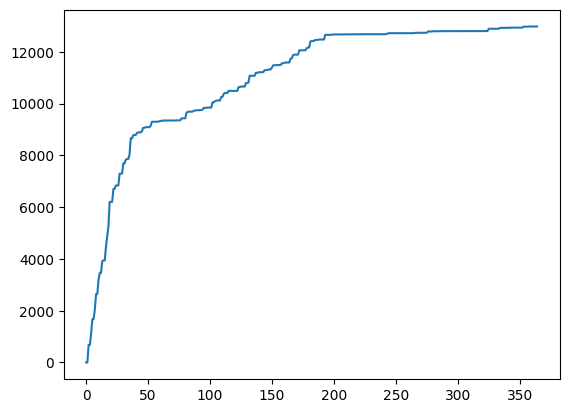

In [ ]:
#small experiment
T=365
data_matrix=gen(T)
import matplotlib.pyplot as plt
totreg_real=LETC(data_matrix,theta,l,u,T,para1=3,para2=0.05,para3=0.25)
plt.plot(np.cumsum(totreg_real))

In [ ]:
theta

array([-1.80683974e+02, -2.62286671e+02, -2.94889549e+02, -2.01897303e+02,
       -2.11755496e+02, -2.31950042e+02, -2.43226470e+02,  4.75746220e+00,
        4.75746220e+00,  8.25721699e+00,  1.18677863e+01,  1.32406745e+01,
        9.48884155e+00,  9.25802541e+00,  8.02651125e+00,  8.44074351e+00,
       -1.60629945e-01, -1.60629945e-01])

# ***Regret: Offline***

In [ ]:
###regret for offline price model and plot
def offline_model_regret(data_matrix,theta,l,u,T,pricemodel):
  totreg=[]
  d=len(theta)//2
  xt=data_matrix.iloc[0:T]
  if pricemodel=='Linear':
    parray=pricemodel_linear.predict(xt)
  elif pricemodel=='Kernel Ridge':
    parray=pricemodel_krr.predict(xt)
  xt=xt.to_numpy()
  for t in range(T):
    regt=regret(theta[0:d],theta[d:2*d],xt[t],max(min(parray[t],u),l))
    totreg.append(regt)
  return totreg

seed=[(2024+100000*i)%10007 for i in range(20)]
T=365
d=len(theta)//2
time_range=range(20,T,20)

from time import time
#############Linear
time_prev=time()

reg_linear=np.zeros([len(seed),len(time_range)])
for inds in range(len(seed)):
  s=seed[inds]
  np.random.seed(s)
  data_matrix=gen(T,is_df=1)
  indt=0
  print(inds)
  for t in time_range:
      totreg1=offline_model_regret(data_matrix,theta,l,u,t,pricemodel='Linear')
      reg_linear[inds,indt]=np.sum(totreg1)
      print(reg_linear[inds,indt])
      indt+=1

print(time()-time_prev)


#############Kernel Ridge
time_prev=time()

reg_krr=np.zeros([len(seed),len(time_range)])
for inds in range(len(seed)):
  s=seed[inds]
  np.random.seed(s)
  data_matrix=gen(T,is_df=1)
  indt=0
  print(inds)
  for t in time_range:
      totreg1=offline_model_regret(data_matrix,theta,l,u,t,pricemodel='Kernel Ridge')
      reg_krr[inds,indt]=np.sum(totreg1)
      print(reg_krr[inds,indt])
      indt+=1

print(time()-time_prev)

0
2716.7287286463393
6494.17688298961
8498.432786488449
10753.980419427859
14438.196747155962
16588.529139825812
19619.395383537914
22074.36144186539
25543.905390812484
28751.544364669997
31470.786704764912
33914.54186786339
37914.171840933486
42193.513684428675
45083.75320688617
47815.93129341669
50372.812243183704
52636.44757811085
1
3470.19496066558
6320.365843328653
9931.828008956565
13924.121824233753
17955.294319735083
21323.09717361152
24548.24866207099
28249.502475125544
30254.835554768943
33677.451890165976
37173.70236939066
39666.16687851523
43094.00992913352
46108.871553018165
48950.91450017417
50966.65467833047
54390.41793965256
58148.01540430573
2
3400.0912817818157
7148.139371125555
9438.46610486878
12522.95258946243
16273.901843758313
18565.806330408348
21841.104016174882
24595.630424400377
27265.56395507379
29891.080288958823
32877.871515896026
35631.636135819455
38988.2091903992
42876.00491379325
47399.0247832135
49942.951541007
53304.86573613639
56621.23968664913
3
29

(array([[ 40.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0., 127.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0., 126.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0., 218.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,  19.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,  21.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,  15.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   7.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  21.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  16.]]),
 array([20.51 , 24.154, 27.798, 31.442, 35.086, 38.73 , 42.374, 46.018,
        49.662, 53.306, 56.95 ]),
 array([20.51 , 24.154, 27.798, 31.442, 35.086, 38.73 , 42.374, 46.018,
        49.662, 53.306, 56.95 ]),
 <matplotlib.collections.QuadMesh at 0x7fd3b319b760>)

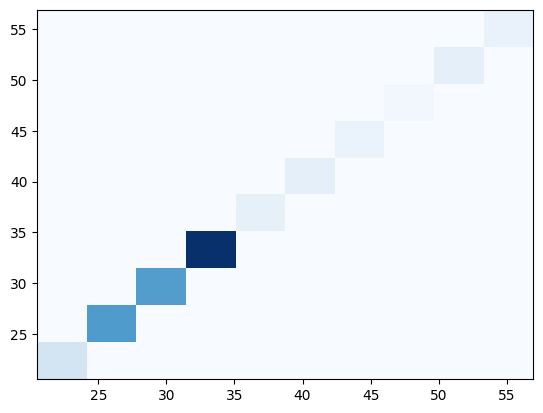

In [ ]:
plt.hist2d(df['comp_data_min_price'],df['comp_data_max_price'],cmap='Blues')

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0., 610.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([-0.5       , -0.46666667, -0.43333333, -0.4       , -0.36666667,
        -0.33333333, -0.3       , -0.26666667, -0.23333333, -0.2       ,
        -0.16666667, -0.13333333, -0.1       , -0.06666667, -0.03333333,
         0.        ,  0.03333333,  0.06666667,  0.1       ,  0.13333333,
         0.16666667,  0.2       ,  0.23333333,  0.26666667,  0.3       ,
         0.33333333,  0.36666667,  0.4       ,  0.43333333,  0.46666667,
         0.5       ]),
 <BarContainer object of 30 artists>)

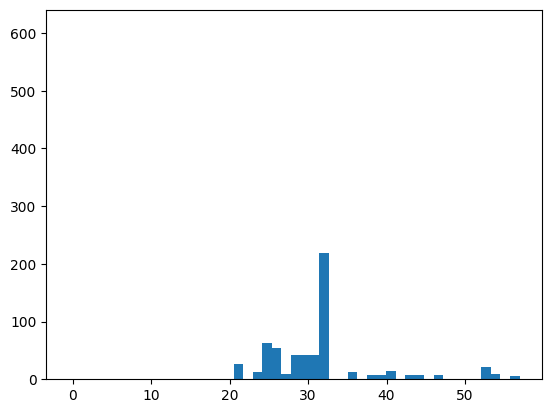

In [ ]:
plt.hist(df['comp_data_min_price'],bins=30)
plt.hist(df['comp_data_max_price']-df['comp_data_min_price'],bins=30)

# ***Regret: LETC(Doubling Trick)***

In [ ]:
seed=[(2024+1000000*i)%100007 for i in range(20)]
from time import time
time_prev=time()

reg_dt=np.zeros([len(seed),2*T])
for inds in range(len(seed)):
  s=seed[inds]
  np.random.seed(s)
  data_matrix=gen(T)
  indt=0
  print(inds)
  ini_t=8
  sum_t=0
  t=ini_t
  while sum_t<T:
    reg_dt[inds,sum_t:sum_t+t]=LETC(data_matrix,theta,l,u,t,para1=3,para2=0.05,para3=0.25)
    sum_t+=t
    t*=2

print(time()-time_prev)

0
0.5751844255720374
[2, 6, 8]
0.5584946116588551
[4, 12, 16]
0.5250691410190936
[6, 21, 32]
0.4836705215732932
[11, 40, 64]
0.43930436145725915
[18, 75, 128]
0.3949153271601239
[29, 143, 256]
1
0.5751844255720374
[2, 6, 8]
0.5584946116588551
[4, 12, 16]
0.5250691410190936
[6, 21, 32]
0.4836705215732932
[11, 40, 64]
0.43930436145725915
[18, 75, 128]
0.3949153271601239
[29, 143, 256]
2
0.5751844255720374
[2, 6, 8]
0.5584946116588551
[4, 12, 16]
0.5250691410190936
[6, 21, 32]
0.4836705215732932
[11, 40, 64]
0.43930436145725915
[18, 75, 128]
0.3949153271601239
[29, 143, 256]
3
0.5751844255720374
[2, 6, 8]
0.5584946116588551
[4, 12, 16]
0.5250691410190936
[6, 21, 32]
0.4836705215732932
[11, 40, 64]
0.43930436145725915
[18, 75, 128]
0.3949153271601239
[29, 143, 256]
4
0.5751844255720374
[2, 6, 8]
0.5584946116588551
[4, 12, 16]
0.5250691410190936
[6, 21, 32]
0.4836705215732932
[11, 40, 64]
0.43930436145725915
[18, 75, 128]
0.3949153271601239
[29, 143, 256]
5
0.5751844255720374
[2, 6, 8]
0.55

<ipython-input-34-02ce4ae87974>:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bottom=0)


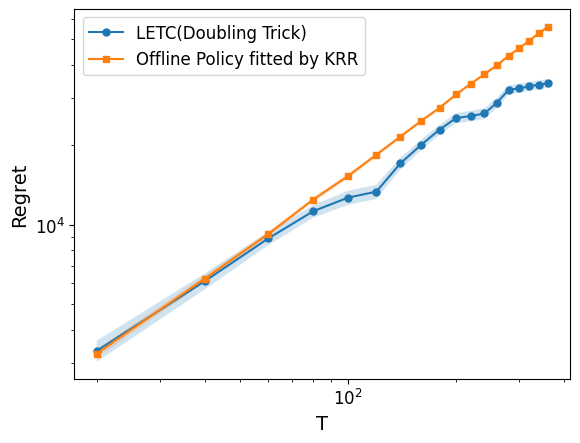

In [ ]:
plt.figure(4)
from google.colab import files
reg=np.zeros([len(seed),len(time_range)])
for i in range(len(seed)):
  for j in range(len(time_range)):
    reg[i,j]=np.sum(reg_dt[i,0:time_range[j]])

dot_types = ['o', '^', 's', 'D', '*']
color_types = ['b', 'g', 'r', 'c', 'm']

plt.loglog(time_range,np.mean(reg,axis=0),label='LETC(Doubling Trick)',marker='o',markersize=5)
plt.loglog(time_range,np.mean(reg_krr,axis=0),label='Offline Policy fitted by KRR',marker='s',markersize=5)
plt.fill_between(time_range,np.mean(reg,axis=0)-np.std(reg,axis=0)/np.sqrt(len(seed)),
np.mean(reg,axis=0)+np.std(reg,axis=0)/np.sqrt(len(seed)),alpha=0.2)
plt.fill_between(time_range,np.mean(reg_krr,axis=0)-np.std(reg_krr,axis=0)/np.sqrt(len(seed)),
np.mean(reg_krr,axis=0)+np.std(reg_krr,axis=0)/np.sqrt(len(seed)),alpha=0.2)

plt.ylim(bottom=0)
plt.xlabel('T',fontsize=14)
plt.ylabel('Regret',fontsize=14)
plt.xticks(fontsize=12)  # Font size for X-axis ticks
plt.yticks(fontsize=12)  # Font size for Y-axis ticks
plt.legend(fontsize=12)
plt.savefig(f'regret-prod{selected+1}.pdf')